이 자료는 위키독스 '딥 러닝을 이용한 자연어 처리 입문'의 트랜스포머 튜토리얼로 작성되었습니다.  
2021년 10월 8일에 정상 동작을 확인하였습니다.  

챗봇의 성능이 아쉽다면 모델의 크기를 조정해보세요.

링크 :  
https://wikidocs.net/31379  
https://wikidocs.net/89786

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
tf.__version__

'2.6.1'

In [3]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)
    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

(1, 50, 128)


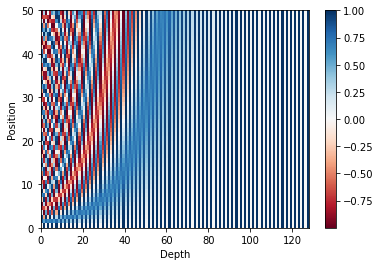

In [4]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [5]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [7]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [8]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [9]:
# @@@@수정됨
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [10]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [11]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [12]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [13]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [14]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

(1, 9000, 128)
(1, 9000, 128)
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [16]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

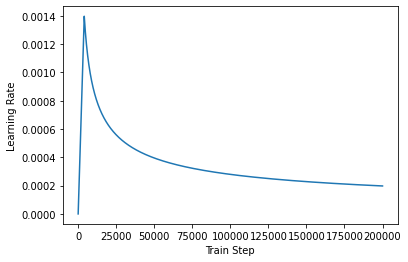

In [17]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# 여기서부터 챗봇 개발

In [18]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [19]:
train_data = pd.read_csv('intetraining2.csv')
train_data.head()

,q,a
0,코로나 검사결과는 언제 나와요?,6시간에서 하루 정도 소요됩니다.
1,결과는 어떻게 알 수 있어요?,"문자로 양성, 음성 여부를 알려줍니다. ."
2,하루가 지나도 연락이 안오면 어떻게 해요?,검사 받으신 진료소로 전화주셔서 확인하시면 됩니다.
3,친구 아버지가 돌아가셨는데 장례식장에 가도 돼요?,"가셔도 되지만, 가급적 사람들이 많이 모이는 곳은 피하시는 것이 좋습니다."
4,장례식장에 마스크 안끼고 가도 돼요?,마스크는 꼭 착용하셔야 합니다.


In [20]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 7451


In [21]:
print(train_data.isnull().sum())

q    0
a    0
dtype: int64


In [22]:
questions = []
for sentence in train_data['q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)

In [23]:
answers = []
for sentence in train_data['a']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [24]:
len(questions)

7451

In [25]:
print(questions[:5])
print(answers[:5])

['코로나 검사결과는 언제 나와요 ?', '결과는 어떻게 알 수 있어요 ?', '하루가 지나도 연락이 안오면 어떻게 해요 ?', '친구 아버지가 돌아가셨는데 장례식장에 가도 돼요 ?', '장례식장에 마스크 안끼고 가도 돼요 ?']
['6시간에서 하루 정도 소요됩니다 .', '문자로 양성 ,  음성 여부를 알려줍니다 .   .', '검사 받으신 진료소로 전화주셔서 확인하시면 됩니다 .', '가셔도 되지만 ,  가급적 사람들이 많이 모이는 곳은 피하시는 것이 좋습니다 .', '마스크는 꼭 착용하셔야 합니다 .']


In [26]:
# coding=utf-8
# Copyright 2018 Google AI, Google Brain and Carnegie Mellon University Authors and the HuggingFace Inc. team and Jangwon Park
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
""" Tokenization classes for KoBERT model """


import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer

logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {
    "vocab_file": "tokenizer_78b3253a26.model",
    "vocab_txt": "vocab.txt",
}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model",
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt",
    },
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512,
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False},
}

SPIECE_UNDERLINE = "▁"


class KoBertTokenizer(PreTrainedTokenizer):
    """
    SentencePiece based tokenizer. Peculiarities:
        - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """

    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
        self,
        vocab_file,
        vocab_txt,
        do_lower_case=False,
        remove_space=True,
        keep_accents=False,
        unk_token="[UNK]",
        sep_token="[SEP]",
        pad_token="[PAD]",
        cls_token="[CLS]",
        mask_token="[MASK]",
        **kwargs,
    ):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs,
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, "r", encoding="utf-8") as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning(
                "You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                "pip install sentencepiece"
            )

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning(
                "You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                "pip install sentencepiece"
            )
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize("NFKD", outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text):
        """Tokenize a string."""
        text = self.preprocess_text(text)
        pieces = self.sp_model.encode(text, out_type=str)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(
                map(
                    lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0,
                    token_ids_0,
                )
            )

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """Save the sentencepiece vocabulary (copy original file) and special tokens file
        to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [27]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8002]
종료 토큰 번호 : [8003]
단어 집합의 크기 : 8004


In [28]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [2, 1202, 3123, 7086, 1907, 6682, 4424, 7789, 5212, 5850, 6999, 3]


In [29]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = questions[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [2, 1202, 3123, 7086, 1907, 6682, 4424, 7789, 5212, 5850, 6999, 3]
기존 문장: [CLS] 그런데 아이들은 마스크 착용하기 힘든데요[SEP]


In [30]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

2 ----> [CLS]
1202 ----> 그런데
3123 ----> 아이들
7086 ----> 은
1907 ----> 마
6682 ----> 스크
4424 ----> 착용
7789 ----> 하기
5212 ----> 힘든
5850 ----> 데
6999 ----> 요
3 ----> [SEP]


In [31]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [32]:
questions, answers = tokenize_and_filter(questions, answers)

In [33]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (7451, 40)
답변 데이터의 크기(shape) : (7451, 40)


In [34]:
# 0번째 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8002    2 4665 6079 5655  897 5416 5760 3245 1394 6999  633    3 8003
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8002    2  617 6706 6903 4937 4099 2843 5906  517   54    3 8003    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [35]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8004
전체 샘플의 수(Number of samples): 7451


In [36]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [37]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8002    2  617 6706 6903 4937 4099 2843 5906  517   54    3 8003    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8002    2  617 6706 6903 4937 4099 2843 5906  517   54    3 8003    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[   2  617 6706 6903 4937 4099 2843 5906  517   54    3 8003    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [38]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8004, 256)
(1, 8004, 256)


In [39]:
MAX_LENGTH = 40

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [40]:
EPOCHS = 1000
model.fit(dataset, epochs=EPOCHS)

Epoch 1/1000
117/117 [==============================] - 16s 90ms/step - loss: 3.9957 - accuracy: 0.0211
Epoch 2/1000
117/117 [==============================] - 11s 90ms/step - loss: 3.3897 - accuracy: 0.0736
Epoch 3/1000
117/117 [==============================] - 11s 93ms/step - loss: 2.6596 - accuracy: 0.1279
Epoch 4/1000
117/117 [==============================] - 11s 95ms/step - loss: 2.2159 - accuracy: 0.1439
Epoch 5/1000
117/117 [==============================] - 11s 96ms/step - loss: 1.8948 - accuracy: 0.1837
Epoch 6/1000
117/117 [==============================] - 12s 99ms/step - loss: 1.6348 - accuracy: 0.2076
Epoch 7/1000
117/117 [==============================] - 12s 100ms/step - loss: 1.4342 - accuracy: 0.2283
Epoch 8/1000
117/117 [==============================] - 12s 100ms/step - loss: 1.2658 - accuracy: 0.2467s - loss: 1.2664 - accuracy: 
Epoch 9/1000
117/117 [==============================] - 12s 101ms/step - loss: 1.1174 - accuracy: 0.2634
Epoch 10/1000
117/117 [=========

117/117 [==============================] - 13s 108ms/step - loss: 0.0317 - accuracy: 0.4503
Epoch 78/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0313 - accuracy: 0.4503
Epoch 79/1000
117/117 [==============================] - 13s 113ms/step - loss: 0.0309 - accuracy: 0.4504
Epoch 80/1000
117/117 [==============================] - 13s 113ms/step - loss: 0.0312 - accuracy: 0.4503
Epoch 81/1000
117/117 [==============================] - 13s 113ms/step - loss: 0.0300 - accuracy: 0.4506
Epoch 82/1000
117/117 [==============================] - 13s 114ms/step - loss: 0.0299 - accuracy: 0.4507
Epoch 83/1000
117/117 [==============================] - 14s 116ms/step - loss: 0.0293 - accuracy: 0.4505
Epoch 84/1000
117/117 [==============================] - 14s 116ms/step - loss: 0.0294 - accuracy: 0.4509
Epoch 85/1000
117/117 [==============================] - 14s 116ms/step - loss: 0.0288 - accuracy: 0.4510
Epoch 86/1000
117/117 [==============================] - 14s

117/117 [==============================] - 13s 111ms/step - loss: 0.0187 - accuracy: 0.4533
Epoch 154/1000
117/117 [==============================] - 14s 117ms/step - loss: 0.0184 - accuracy: 0.4534
Epoch 155/1000
117/117 [==============================] - 14s 116ms/step - loss: 0.0184 - accuracy: 0.4535
Epoch 156/1000
117/117 [==============================] - 14s 118ms/step - loss: 0.0184 - accuracy: 0.4532
Epoch 157/1000
117/117 [==============================] - 14s 117ms/step - loss: 0.0183 - accuracy: 0.4533
Epoch 158/1000
117/117 [==============================] - 15s 126ms/step - loss: 0.0185 - accuracy: 0.4533
Epoch 159/1000
117/117 [==============================] - 14s 118ms/step - loss: 0.0183 - accuracy: 0.4533
Epoch 160/1000
117/117 [==============================] - 14s 118ms/step - loss: 0.0183 - accuracy: 0.4534
Epoch 161/1000
117/117 [==============================] - 13s 113ms/step - loss: 0.0183 - accuracy: 0.4534
Epoch 162/1000
117/117 [============================

117/117 [==============================] - 13s 109ms/step - loss: 0.0153 - accuracy: 0.4540
Epoch 230/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0155 - accuracy: 0.4540
Epoch 231/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0152 - accuracy: 0.4540
Epoch 232/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0151 - accuracy: 0.4541
Epoch 233/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0156 - accuracy: 0.4539
Epoch 234/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0153 - accuracy: 0.4539
Epoch 235/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0155 - accuracy: 0.4539
Epoch 236/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0151 - accuracy: 0.4540
Epoch 237/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0152 - accuracy: 0.4540
Epoch 238/1000
117/117 [============================

117/117 [==============================] - 13s 109ms/step - loss: 0.0141 - accuracy: 0.4541
Epoch 306/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0142 - accuracy: 0.4543
Epoch 307/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0140 - accuracy: 0.4544
Epoch 308/1000
117/117 [==============================] - 13s 115ms/step - loss: 0.0139 - accuracy: 0.4544
Epoch 309/1000
117/117 [==============================] - 14s 121ms/step - loss: 0.0141 - accuracy: 0.4542
Epoch 310/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0140 - accuracy: 0.4541
Epoch 311/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0142 - accuracy: 0.4544
Epoch 312/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0141 - accuracy: 0.4542
Epoch 313/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0139 - accuracy: 0.4541
Epoch 314/1000
117/117 [============================

117/117 [==============================] - 13s 110ms/step - loss: 0.0133 - accuracy: 0.4544
Epoch 382/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0133 - accuracy: 0.4543
Epoch 383/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0134 - accuracy: 0.4544
Epoch 384/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0134 - accuracy: 0.4543
Epoch 385/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0135 - accuracy: 0.4544
Epoch 386/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0129 - accuracy: 0.4544
Epoch 387/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0131 - accuracy: 0.4546
Epoch 388/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0134 - accuracy: 0.4544
Epoch 389/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0131 - accuracy: 0.4544
Epoch 390/1000
117/117 [============================

117/117 [==============================] - 13s 111ms/step - loss: 0.0131 - accuracy: 0.4544
Epoch 458/1000
117/117 [==============================] - 13s 114ms/step - loss: 0.0128 - accuracy: 0.4546
Epoch 459/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0127 - accuracy: 0.4545
Epoch 460/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0129 - accuracy: 0.4545
Epoch 461/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0128 - accuracy: 0.4545
Epoch 462/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0131 - accuracy: 0.4545
Epoch 463/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0128 - accuracy: 0.4546
Epoch 464/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0129 - accuracy: 0.4545
Epoch 465/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0129 - accuracy: 0.4546
Epoch 466/1000
117/117 [============================

117/117 [==============================] - 13s 109ms/step - loss: 0.0126 - accuracy: 0.4546
Epoch 534/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0126 - accuracy: 0.4546
Epoch 535/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0125 - accuracy: 0.4547
Epoch 536/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0125 - accuracy: 0.4546
Epoch 537/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0125 - accuracy: 0.4546
Epoch 538/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0124 - accuracy: 0.4547
Epoch 539/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0125 - accuracy: 0.4546
Epoch 540/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0124 - accuracy: 0.4546
Epoch 541/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0125 - accuracy: 0.4547
Epoch 542/1000
117/117 [============================

117/117 [==============================] - 13s 109ms/step - loss: 0.0123 - accuracy: 0.4547
Epoch 610/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0123 - accuracy: 0.4546
Epoch 611/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0125 - accuracy: 0.4546
Epoch 612/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0123 - accuracy: 0.4547
Epoch 613/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0125 - accuracy: 0.4547
Epoch 614/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0125 - accuracy: 0.4547
Epoch 615/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0123 - accuracy: 0.4547
Epoch 616/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0124 - accuracy: 0.4547
Epoch 617/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0123 - accuracy: 0.4546
Epoch 618/1000
117/117 [============================

117/117 [==============================] - 13s 110ms/step - loss: 0.0119 - accuracy: 0.4548
Epoch 686/1000
117/117 [==============================] - 13s 111ms/step - loss: 0.0122 - accuracy: 0.4548
Epoch 687/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0121 - accuracy: 0.4548
Epoch 688/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0121 - accuracy: 0.4547
Epoch 689/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0121 - accuracy: 0.4548
Epoch 690/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0122 - accuracy: 0.4548
Epoch 691/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0121 - accuracy: 0.4549
Epoch 692/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0121 - accuracy: 0.4548
Epoch 693/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0123 - accuracy: 0.4548
Epoch 694/1000
117/117 [============================

117/117 [==============================] - 13s 109ms/step - loss: 0.0120 - accuracy: 0.4548
Epoch 762/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0120 - accuracy: 0.4548
Epoch 763/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0120 - accuracy: 0.4548
Epoch 764/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0120 - accuracy: 0.4548
Epoch 765/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0119 - accuracy: 0.4547
Epoch 766/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0121 - accuracy: 0.4547
Epoch 767/1000
117/117 [==============================] - 13s 110ms/step - loss: 0.0118 - accuracy: 0.4548
Epoch 768/1000
117/117 [==============================] - 13s 109ms/step - loss: 0.0119 - accuracy: 0.4548
Epoch 769/1000
117/117 [==============================] - 15s 125ms/step - loss: 0.0121 - accuracy: 0.4547
Epoch 770/1000
117/117 [============================

KeyboardInterrupt: 

In [41]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [42]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [43]:
# 딥러닝 model 객체 저장.

model.save_weights('conversation_weight_data1111')

In [57]:
output = predict('무료로 검사해주는 사유는 무엇인가요?')

Input: 무료로 검사해주는 사유는 무엇인가요?
Output: [CLS] 질병의 확산 방지를 위해 적극적인 검사에 참여토록 하기 위함입니다.[SEP]


In [45]:
output = predict("백신 부작용")

Input: 백신 부작용
Output: [CLS] 네, 장기능 장애, 저혈압등의 부작용을 보였습니다.[SEP]


In [46]:
output = predict("코로나 백신 접종되나요?")

Input: 코로나 백신 접종되나요?
Output: [CLS] 네, 궁금하신 점이 있으신가요?[SEP]


In [47]:
output = predict("코로나 검사를 받고 싶어요")

Input: 코로나 검사를 받고 싶어요
Output: [CLS] 가까운 보건소에서 받으시면 됩니다.[SEP]


In [59]:
output = predict("열나요")

Input: 열나요
Output: [CLS] 일단, 증상이 심하시면 병원으로 보내야 해요.[SEP]


In [49]:
output = predict("마스크 착용해야 되요?")

Input: 마스크 착용해야 되요?
Output: [CLS] 머리 끈을 아래로 늘어뜨리고 코와 턱이 감싸지도지도록 얼굴에 하세요.[SEP]


In [50]:
output = predict("치료약 있나요")

Input: 치료약 있나요
Output: [CLS] 네[SEP]


In [51]:
output = predict("자가격리 되면 아침은 어떻게 먹나요?")

Input: 자가격리 되면 아침은 어떻게 먹나요?
Output: [CLS] 개별적으로 해결해야 합니다.[SEP]


In [52]:
output = predict("백신은 언제 맞을까요?")

Input: 백신은 언제 맞을까요?
Output: [CLS] 현재 개발단계입니다.[SEP]


In [53]:
output = predict("39조 어케될까?")

Input: 39조 어케될까?
Output: [CLS] 독감으로 인해 열이 나면 코로나 검사를 받아야 한다고 생각들 하셔서 그런것 같습니다.[SEP]


In [54]:
output = predict("백신 부작용은?")

Input: 백신 부작용은?
Output: [CLS] 네, 장기능 장애, 저혈압등의 부작용을 보였습니다.[SEP]


In [ ]:
output = predict("오늘의 날씨는?")

In [55]:
output = predict("안녕하세요")

Input: 안녕하세요
Output: [CLS] 안녕하세요[SEP]
